In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [45]:
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from benchmarking.data import dataset_loaders, DatasetGroup
from hnne.v2_plotter import format_time, format_count, plot_projection_grid, plot_v2_nested_2d, plot_layout_level_2d
from hnne.hierarchical_projection import multi_step_projection
from hnne.projector import HNNE

# Run on downloaded datasets

### Dowload all hnne datasets as used in the paper as tar file (https://bwsyncandshare.kit.edu/s/Bp4gwZ4xcgj7otG). see the example loader below

In [50]:
data_path = Path(module_path, 'hnne_datasets')
## Load small, medium or large datasets, see ./hnne/benchmarking/data.py
loaders = dataset_loaders(dataset_group=DatasetGroup.small)
loaders.keys()

dict_keys(['coil_20', 'shuttle', 'mnist', 'fmnist'])

In [54]:
random_state=42
dataset_name = 'coil_20' #'cifar_10'
data, targets = loaders[dataset_name](data_path)
prefered_num_clust = len(set(targets))
prefered_num_clust

20

## run FINCH

In [55]:

partitions, requested_partition, partition_sizes, partition_labels = HNNE(random_state=random_state, prefered_num_clust=None, metric='cosine').fit_only_hierarchy(data)
finch_output = [partitions,requested_partition, partition_sizes, partition_labels]

In [56]:
partition_sizes

[447, 116, 31, 9]

## h-NNE v1 vs h-NNE v2

In [57]:
def wrapper(data,finch_output,
            v1_behaviour=False,
            preliminary_embedding='pca',
            # v2 knobs 
            v2=True,
            v2_k=1,
            prefered_num_clust=None,
            v2_size_threshold=500,
            # start-at target (optional)
            start_cluster_view=None,
            random_state=42):
    
    partitions, requested_partition, partition_sizes, partition_labels = finch_output 
    
    projection, _, _, _, _, _, _, _, v2_layout, time_elapsed = multi_step_projection(
    data=data,
    partitions=partitions,
    partition_labels=partition_labels,
    radius=0.4,
    ann_threshold=40000,
    dim=2,
    partition_sizes=partition_sizes,
    preliminary_embedding=preliminary_embedding,
    random_state=42,
    v1_behaviour=v1_behaviour, 
    v2=v2,
    v2_k=v2_k,
    prefered_num_clust=prefered_num_clust,
    requested_partition=requested_partition,    
    v2_size_threshold=v2_size_threshold,
    start_cluster_view=start_cluster_view,  
    verbose=False,
    )
    return projection, v2_layout, time_elapsed

In [21]:
%%time
hnne_v1, _, _= wrapper(data,finch_output, v1_behaviour=True, v2=False, prefered_num_clust=None, start_cluster_view=None, v2_size_threshold=None)


CPU times: user 36.8 s, sys: 9.84 s, total: 46.6 s
Wall time: 6.86 s


In [12]:
hnne_v2_top1, _, _ = wrapper(data,finch_output, v1_behaviour=False, v2=True, prefered_num_clust=None, start_cluster_view=None, v2_size_threshold=50)

In [13]:
%%time
hnne_v2,_ , _= wrapper(data,finch_output, v1_behaviour=False, v2=True, prefered_num_clust=None, start_cluster_view=10, v2_size_threshold=50)

CPU times: user 37.4 s, sys: 6.29 s, total: 43.7 s
Wall time: 6.76 s


In [14]:
%%time
hnne_v2_level_2_start, _, _ = wrapper(data,finch_output, v1_behaviour=False, v2=True, prefered_num_clust=None, start_cluster_view=50, v2_size_threshold=500)

CPU times: user 37.5 s, sys: 6.57 s, total: 44 s
Wall time: 7.9 s


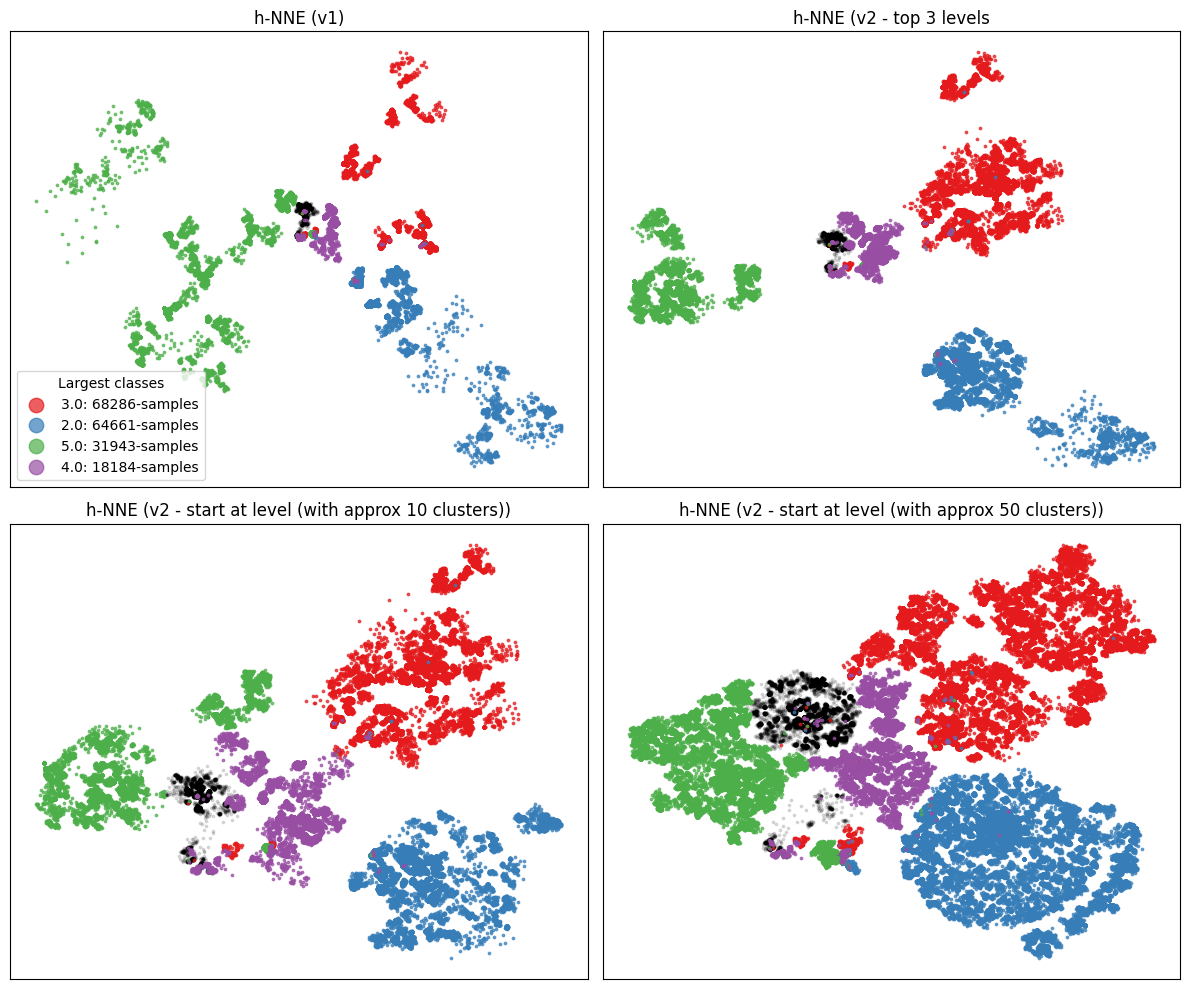

In [23]:
plt = plot_projection_grid(
    [hnne_v1, hnne_v2_top1, hnne_v2, hnne_v2_level_2_start],
    labels=targets, #partitions[:, -2],  # or None
    titles=("h-NNE (v1)", "h-NNE (v2 - top 3 levels", "h-NNE (v2 - start at level (with approx 10 clusters))", "h-NNE (v2 - start at level (with approx 50 clusters))"),
    point_size=3,
    other_color='#000000',
    equal_aspect=False,        # set True if projection scales are comparable
    show=False
)
plt.show()

## h-nne v2 at only a single level

In [18]:
partition_sizes

[49316, 11032, 2543, 421, 41, 8, 3]

In [25]:
sel_levels = np.array([10, 50, 500, 3000])
start= {}
for lev in sel_levels:
    idx = np.argmin(np.abs(np.array(partition_sizes) - lev))
    start[str(lev)] = partition_sizes[idx]

In [30]:
%%time
hnne_v2_large_level_10_fix, v2_layout_10, _ = wrapper(data,finch_output, preliminary_embedding='pca', v1_behaviour=False, v2=True, start_cluster_view=start['10'], v2_size_threshold=start['10'])

CPU times: user 36.7 s, sys: 5.51 s, total: 42.2 s
Wall time: 6.46 s


In [31]:
%%time
hnne_v2_large_level_50_fix, v2_layout_50, _ = wrapper(data,finch_output, preliminary_embedding='pca', v1_behaviour=False, v2=True, start_cluster_view=start['50'], v2_size_threshold=start['50'])

CPU times: user 33.4 s, sys: 6.26 s, total: 39.7 s
Wall time: 6.04 s


In [32]:
%%time
hnne_v2_large_level_500_fix, v2_layout_500, _ = wrapper(data,finch_output, preliminary_embedding='pca', v1_behaviour=False, v2=True, start_cluster_view=start['500'], v2_size_threshold=start['500'])

CPU times: user 34.6 s, sys: 6.24 s, total: 40.8 s
Wall time: 6.59 s


In [33]:
%%time
hnne_v2_large_level_3000_fix, v2_layout_3000, _ = wrapper(data,finch_output, preliminary_embedding='pca', v1_behaviour=False, v2=True, start_cluster_view=start['3000'], v2_size_threshold=start['3000'])

CPU times: user 46.1 s, sys: 5.57 s, total: 51.6 s
Wall time: 18.8 s


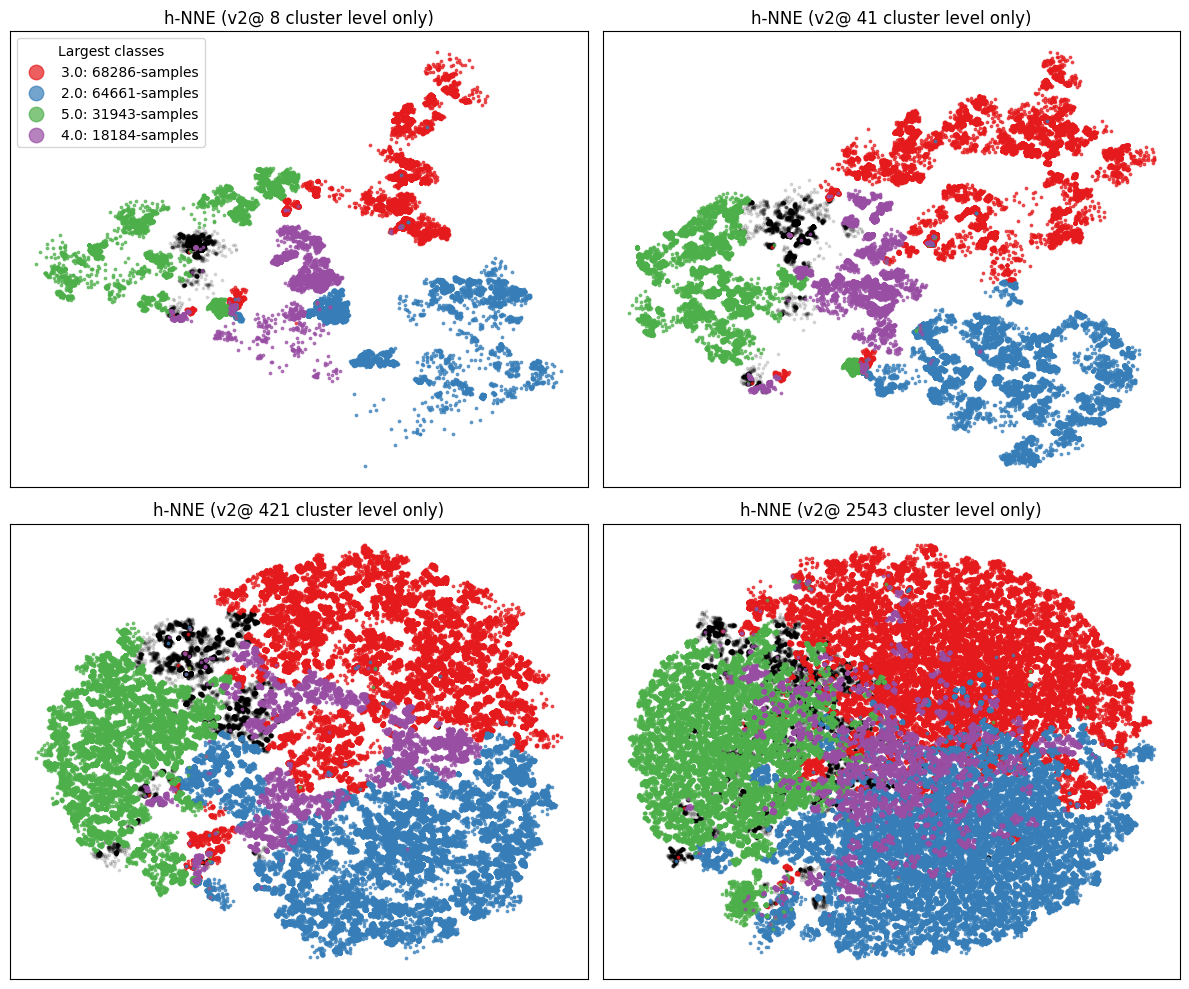

In [35]:
title_str = [f'h-NNE (v2@ {start[str(j)]} cluster level only)' for j in sel_levels]
_ = plot_projection_grid(
    [hnne_v2_large_level_10_fix, hnne_v2_large_level_50_fix, hnne_v2_large_level_500_fix, hnne_v2_large_level_3000_fix],
    labels=targets,             # or None
    titles=title_str,
    point_size=3,
    other_color='#000000',
    equal_aspect=False,        # set True if projection scales are comparable
)

## tmp plots for paper

In [58]:
%%time
hnne_v2_large_level_10_fix, v2_layout_10, time_elapsed = wrapper(data,finch_output, preliminary_embedding='pca', v1_behaviour=False, v2=True, v2_k=1, prefered_num_clust=None, start_cluster_view=10, v2_size_threshold=500)

CPU times: user 6.5 s, sys: 2.34 s, total: 8.84 s
Wall time: 3.5 s


In [59]:
partition_sizes

[447, 116, 31, 9]

In [61]:
parent_level=3
child_levels=[0]
sel_part = partitions[:, [0,1,2,3]]
num_child = [len(set(sel_part[:, j])) for j in child_levels]
num_child = '_'.join(map(str,num_child))
name = str(f'level_{len(set(sel_part[:, parent_level]))}_{num_child}')


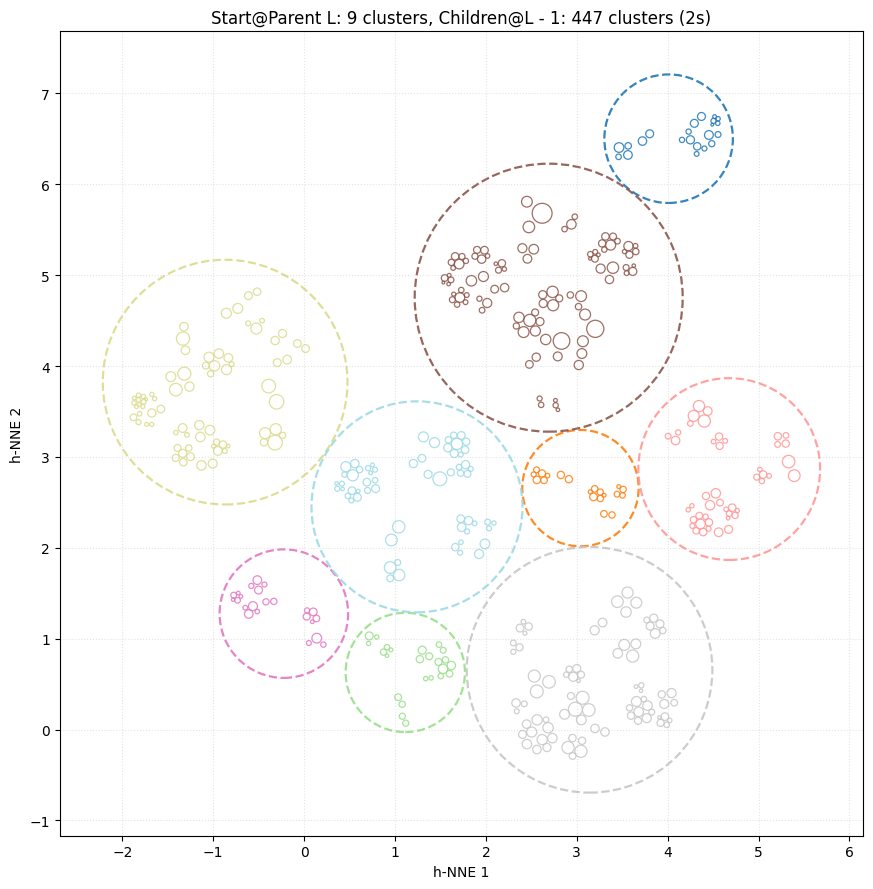

In [62]:

plt = plot_v2_nested_2d(
    v2_layout_10,
    sel_part,
    parent_level=parent_level,
    child_levels=child_levels,
    draw_parent_labels=False,
    draw_child_labels=False,
    time_elapsed=time_elapsed
)
#plt.savefig(f"./visualization_imgs/{name}.jpg")
plt.show()


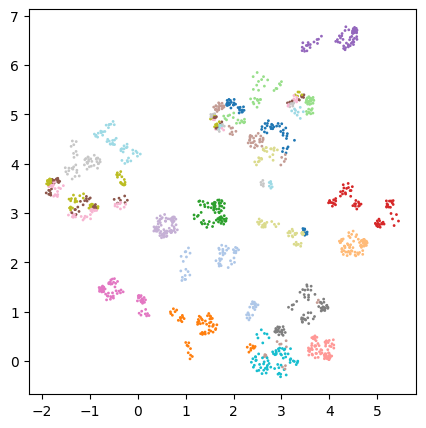

In [63]:
ig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(*hnne_v2_large_level_10_fix.T, s=1, c=targets, cmap='tab20')
plt.show()